## GED conflict data clean up

In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
##set a working directory
user = os.path.expanduser('~')
display(user)

os.makedirs(f'{user}/Desktop/thesis/', exist_ok=True)
path = os.chdir(f'{user}/Desktop/'+'thesis/')

'/Users/NatStrom'

In [3]:
data = pd.read_csv('GEDEvent_v22_1.csv')

/var/folders/3l/pgxm2f9j3bbgbjcj2pyxl__00000gp/T/ipykernel_37040/2663555733.py:1: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('GEDEvent_v22_1.csv')


In [4]:
df = data.copy()

In [5]:
print(df.dtypes)
print(df.columns)
print(df.describe(include='all'))

## sanity check to ensure the spread of the data is correct
print('sanity check 1, ensure appropriate years and countries are represented')
list_country=list(list(df['country_id'].drop_duplicates()))
list_year=list(list(df['year'].drop_duplicates()))
print('country list', list_country)
print('year list', list_year)
#inspect for NAs
print('following checks for completeness of all columns')
print(df['country_id'].isnull().values.any())

id                     int64
relid                 object
year                   int64
active_year            int64
code_status           object
type_of_violence       int64
conflict_dset_id       int64
conflict_new_id        int64
conflict_name         object
dyad_dset_id           int64
dyad_new_id            int64
dyad_name             object
side_a_dset_id         int64
side_a_new_id          int64
side_a                object
side_b_dset_id         int64
side_b_new_id          int64
side_b                object
number_of_sources      int64
source_article        object
source_office         object
source_date           object
source_headline       object
source_original       object
where_prec             int64
where_coordinates     object
where_description     object
adm_1                 object
adm_2                 object
latitude             float64
longitude            float64
geom_wkt              object
priogrid_gid           int64
country               object
country_id    

In [6]:
#filter only the wanted columns
df_filtered = df.filter(['id', 'relid', 'year', 'type_of_violence','conflict_new_id','country_id','best', 'high', 'low'])

In [7]:
display(df_filtered)

id               relid  year  type_of_violence  conflict_new_id  \
0       244657  IRQ-2017-1-524-322  2017                 1              259   
1       412700  IRQ-2021-1-524-145  2021                 1              259   
2       413023  IRQ-2021-1-524-143  2021                 1              259   
3       412909  IRQ-2021-1-524-144  2021                 1              259   
4       132140    AFG-1989-1-411-2  1989                 1              333   
...        ...                 ...   ...               ...              ...   
293629   15525   MZM-1989-3-1347-4  1989                 3              562   
293630   15524  MZM-1989-3-1347-16  1989                 3              562   
293631   15245  MZM-1990-3-1347-18  1990                 3              562   
293632   15516  MZM-1990-3-1347-28  1990                 3              562   
293633   15493  MZM-1990-3-1347-29  1990                 3              562   

        country_id  best  high  low  
0              700     6     6    6  
1              700   183   184  171  
2              700     2     3    0  
3              700    10    10    9  
4              700     6     6    6  
...            ...   ...   ...  ...  
293629         552     9     9    9  
293630         552     9     9    9  
293631         552     7     7    7  
293632         552     1     1    1  
293633         552     6     6    6  

[293634 rows x 9 columns]

In [8]:
from ingester3.scratch import cache_manager

cache_manager()

# This will import the Pandas extensions as well as bootstrap the object layer
from ingester3.extensions import *

In [9]:
#create the c_id from the gw codes
#create c_ids
df_filtered = pd.DataFrame.cy.soft_validate_gwcode_year(df_filtered, gw_col='country_id', year_col = 'year', at_month = 12)
inspect=df_filtered.query("valid_id == False")
print('countries with invalid id below')
display(inspect)

df_filtered = pd.DataFrame.c.from_gwcode(df_filtered, gw_col='country_id', month_col=None)

countries with invalid id below


id              relid  year  type_of_violence  conflict_new_id  \
138842  16107  SAF-1989-3-560-14  1989                 3              477   
138843  17748  SAF-1989-3-560-12  1989                 3              477   

        country_id  best  high  low  valid_id  
138842         565     0   300    0     False  
138843         565     0    27    0     False

In [10]:
df_filtered['Africa'] = df_filtered.c.in_africa

In [11]:
df_filtered = df_filtered.query('Africa == True')

In [12]:
#get the iso numbers
df_filtered['iso'] = df_filtered.c.isoab

In [13]:
inspect = df_filtered.loc[df_filtered.iso.isna()]
display(inspect)

Empty DataFrame
Columns: [id, relid, year, type_of_violence, conflict_new_id, country_id, best, high, low, valid_id, c_id, Africa, iso]
Index: []

In [14]:
df_conflict = df_filtered.copy()

In [15]:
df_conflict = df_conflict.filter(['iso','year','type_of_violence', 'best', 'high', 'low'])
df_conflict

iso  year  type_of_violence  best  high  low
41447   DZA  1990                 1     1     1    1
41448   DZA  1991                 1     3     3    3
41449   DZA  1991                 1     4     4    4
41450   DZA  1991                 1    10    10   10
41451   DZA  1991                 1    17    17   17
...     ...   ...               ...   ...   ...  ...
293629  ZWE  1989                 3     9     9    9
293630  ZWE  1989                 3     9     9    9
293631  ZWE  1990                 3     7     7    7
293632  ZWE  1990                 3     1     1    1
293633  ZWE  1990                 3     6     6    6

[53989 rows x 6 columns]

In [16]:
#now produce the lags and filter out the unwanted years
#now I need to loop the lagging function, creating a new column and appending them all together to then have a dataframe i can concanate

df_conflict['lag_best_5'] = df_conflict.groupby('iso')['best'].shift(5)
df_conflict['lag_best_10'] = df_conflict.groupby('iso')['best'].shift(10)
df_conflict['lag_best_20'] = df_conflict.groupby('iso')['best'].shift(20)

df_conflict = df_conflict.loc[df_conflict['year'] >= 1990]
df_conflict

iso  year  type_of_violence  best  high  low  lag_best_5  lag_best_10  \
41447   DZA  1990                 1     1     1    1         NaN          NaN   
41448   DZA  1991                 1     3     3    3         NaN          NaN   
41449   DZA  1991                 1     4     4    4         NaN          NaN   
41450   DZA  1991                 1    10    10   10         NaN          NaN   
41451   DZA  1991                 1    17    17   17         NaN          NaN   
...     ...   ...               ...   ...   ...  ...         ...          ...   
293627  ZWE  2019                 3     2     2    2         0.0          1.0   
293628  ZWE  2020                 3     2     2    2         1.0          3.0   
293631  ZWE  1990                 3     7     7    7         1.0          1.0   
293632  ZWE  1990                 3     1     1    1         2.0          0.0   
293633  ZWE  1990                 3     6     6    6         2.0          1.0   

        lag_best_20  
41447           NaN  
41448           NaN  
41449           NaN  
41450           NaN  
41451           NaN  
...             ...  
293627          1.0  
293628          1.0  
293631          2.0  
293632         12.0  
293633          3.0  

[53157 rows x 9 columns]

In [25]:
#make a binary predictor of it --> conflict or not and then also high conflict or not, low conflict or not etc
# binary predictor if there is conflict or not and then for the intensity choose a continuous variable?
#log transform the continuous variable

#create dummies
def categorize(row):  
    if row['best'] >= 1 :
        return 1
    return 0

df_conflict['dummy_conflict_lowtreshold'] = df_conflict.apply(lambda row: categorize(row), axis=1)
df_conflict

#create dummies
def categorize(row):  
    if row['best'] >= 25 :
        return 1
    return 0

df_conflict['dummy_conflict_hightreshold'] = df_conflict.apply(lambda row: categorize(row), axis=1)
df_conflict

iso  year  type_of_violence  best  high  low  lag_best_5  lag_best_10  \
41447   DZA  1990                 1     1     1    1         NaN          NaN   
41448   DZA  1991                 1     3     3    3         NaN          NaN   
41449   DZA  1991                 1     4     4    4         NaN          NaN   
41450   DZA  1991                 1    10    10   10         NaN          NaN   
41451   DZA  1991                 1    17    17   17         NaN          NaN   
...     ...   ...               ...   ...   ...  ...         ...          ...   
293627  ZWE  2019                 3     2     2    2         0.0          1.0   
293628  ZWE  2020                 3     2     2    2         1.0          3.0   
293631  ZWE  1990                 3     7     7    7         1.0          1.0   
293632  ZWE  1990                 3     1     1    1         2.0          0.0   
293633  ZWE  1990                 3     6     6    6         2.0          1.0   

        lag_best_20  dummy_conflict  dummy_conflict_lowtreshold  \
41447           NaN               0                           1   
41448           NaN               0                           1   
41449           NaN               0                           1   
41450           NaN               0                           1   
41451           NaN               0                           1   
...             ...             ...                         ...   
293627          1.0               0                           1   
293628          1.0               0                           1   
293631          2.0               0                           1   
293632         12.0               0                           1   
293633          3.0               0                           1   

        dummy_conflict_hightreshold  
41447                             0  
41448                             0  
41449                             0  
41450                             0  
41451                             0  
...                             ...  
293627                            0  
293628                            0  
293631                            0  
293632                            0  
293633                            0  

[53157 rows x 12 columns]

In [26]:
#replace row values
df_conflict['type_of_violence'] = df_conflict['type_of_violence'].map({1:'sb',
                                            2:'ns',
                                            3:'os'})

In [27]:
#create dummies
def categorize(row):  
    if row['type_of_violence'] == 'sb':
        return 1
    return 0

df_conflict['dummy_sb'] = df_conflict.apply(lambda row: categorize(row), axis=1)

# repeat for non-state violence
def categorize(row):  
    if row['type_of_violence'] == 'ns':
        return 1
    return 0

df_conflict['dummy_ns'] = df_conflict.apply(lambda row: categorize(row), axis=1)

#repeat dummy creation for one-sided violence
def categorize(row):  
    if row['type_of_violence'] == 'os':
        return 1
    return 0

df_conflict['dummy_os'] = df_conflict.apply(lambda row: categorize(row), axis=1)



In [28]:
#add dummies for the type of violence
df_conflict

iso  year type_of_violence  best  high  low  lag_best_5  lag_best_10  \
41447   DZA  1990               sb     1     1    1         NaN          NaN   
41448   DZA  1991               sb     3     3    3         NaN          NaN   
41449   DZA  1991               sb     4     4    4         NaN          NaN   
41450   DZA  1991               sb    10    10   10         NaN          NaN   
41451   DZA  1991               sb    17    17   17         NaN          NaN   
...     ...   ...              ...   ...   ...  ...         ...          ...   
293627  ZWE  2019               os     2     2    2         0.0          1.0   
293628  ZWE  2020               os     2     2    2         1.0          3.0   
293631  ZWE  1990               os     7     7    7         1.0          1.0   
293632  ZWE  1990               os     1     1    1         2.0          0.0   
293633  ZWE  1990               os     6     6    6         2.0          1.0   

        lag_best_20  dummy_conflict  dummy_conflict_lowtreshold  \
41447           NaN               0                           1   
41448           NaN               0                           1   
41449           NaN               0                           1   
41450           NaN               0                           1   
41451           NaN               0                           1   
...             ...             ...                         ...   
293627          1.0               0                           1   
293628          1.0               0                           1   
293631          2.0               0                           1   
293632         12.0               0                           1   
293633          3.0               0                           1   

        dummy_conflict_hightreshold  dummy_sb  dummy_ns  dummy_os  
41447                             0         1         0         0  
41448                             0         1         0         0  
41449                             0         1         0         0  
41450                             0         1         0         0  
41451                             0         1         0         0  
...                             ...       ...       ...       ...  
293627                            0         0         0         1  
293628                            0         0         0         1  
293631                            0         0         0         1  
293632                            0         0         0         1  
293633                            0         0         0         1  

[53157 rows x 15 columns]

In [29]:
#create dummies for intensity
def categorize(row):  
    if row['best'] <= 100:
        return 'low'
    if row['best'] > 100 or row['best'] < 1000:
        return 'medium'
    return 'high'

df_conflict['intensity'] = df_conflict.apply(lambda row: categorize(row), axis=1)
df_conflict

iso  year type_of_violence  best  high  low  lag_best_5  lag_best_10  \
41447   DZA  1990               sb     1     1    1         NaN          NaN   
41448   DZA  1991               sb     3     3    3         NaN          NaN   
41449   DZA  1991               sb     4     4    4         NaN          NaN   
41450   DZA  1991               sb    10    10   10         NaN          NaN   
41451   DZA  1991               sb    17    17   17         NaN          NaN   
...     ...   ...              ...   ...   ...  ...         ...          ...   
293627  ZWE  2019               os     2     2    2         0.0          1.0   
293628  ZWE  2020               os     2     2    2         1.0          3.0   
293631  ZWE  1990               os     7     7    7         1.0          1.0   
293632  ZWE  1990               os     1     1    1         2.0          0.0   
293633  ZWE  1990               os     6     6    6         2.0          1.0   

        lag_best_20  dummy_conflict  dummy_conflict_lowtreshold  \
41447           NaN               0                           1   
41448           NaN               0                           1   
41449           NaN               0                           1   
41450           NaN               0                           1   
41451           NaN               0                           1   
...             ...             ...                         ...   
293627          1.0               0                           1   
293628          1.0               0                           1   
293631          2.0               0                           1   
293632         12.0               0                           1   
293633          3.0               0                           1   

        dummy_conflict_hightreshold  dummy_sb  dummy_ns  dummy_os intensity  
41447                             0         1         0         0       low  
41448                             0         1         0         0       low  
41449                             0         1         0         0       low  
41450                             0         1         0         0       low  
41451                             0         1         0         0       low  
...                             ...       ...       ...       ...       ...  
293627                            0         0         0         1       low  
293628                            0         0         0         1       low  
293631                            0         0         0         1       low  
293632                            0         0         0         1       low  
293633                            0         0         0         1       low  

[53157 rows x 16 columns]

In [30]:
# create dummy for low intensity conflict
def categorize(row):  
    if row['intensity'] == 'low':
        return 1
    return 0

df_conflict['dummy_low_intensity'] = df_conflict.apply(lambda row: categorize(row), axis=1)

#repeat dummy creation for medium intensity
def categorize(row):  
    if row['intensity'] == 'middle':
        return 1
    return 0

df_conflict['dummy_medium_intensity'] = df_conflict.apply(lambda row: categorize(row), axis=1)

def categorize(row):  
    if row['intensity'] == 'high':
        return 1
    return 0

df_conflict['dummy_high_intensity'] = df_conflict.apply(lambda row: categorize(row), axis=1)

In [40]:
df_conflict = df_conflict.loc[df_conflict['best'] >= 25]
df_conflict

iso  year type_of_violence  best  high  low  lag_best_5  lag_best_10  \
41457   DZA  1992               sb    31   103   31         2.0          1.0   
41915   DZA  1994               sb    40    40   40         2.0          1.0   
41917   DZA  1994               sb    41    41   41         7.0          1.0   
42034   DZA  1994               sb    26    35   26         3.0          7.0   
42038   DZA  1994               sb    35    35   35        16.0          2.0   
...     ...   ...              ...   ...   ...  ...         ...          ...   
285024  UGA  2000               ns    71    71   71         8.0         20.0   
285025  UGA  2000               ns    71    71   71        70.0          3.0   
285026  UGA  2000               ns    71    71   71         1.0          2.0   
285027  UGA  2000               ns    33    33   33        20.0         26.0   
293614  ZWE  2008               os   197   214  197         0.0          4.0   

        lag_best_20  dummy_conflict  dummy_conflict_lowtreshold  \
41457           NaN               1                           1   
41915           1.0               1                           1   
41917           3.0               1                           1   
42034           2.0               1                           1   
42038           3.0               1                           1   
...             ...             ...                         ...   
285024          8.0               1                           1   
285025         22.0               1                           1   
285026         43.0               1                           1   
285027         32.0               1                           1   
293614          1.0               1                           1   

        dummy_conflict_hightreshold  dummy_sb  dummy_ns  dummy_os intensity  \
41457                             1         1         0         0       low   
41915                             1         1         0         0       low   
41917                             1         1         0         0       low   
42034                             1         1         0         0       low   
42038                             1         1         0         0       low   
...                             ...       ...       ...       ...       ...   
285024                            1         0         1         0       low   
285025                            1         0         1         0       low   
285026                            1         0         1         0       low   
285027                            1         0         1         0       low   
293614                            1         0         0         1    medium   

        dummy_low_intensity  dummy_medium_intensity  dummy_high_intensity  \
41457                     1                       0                     0   
41915                     1                       0                     0   
41917                     1                       0                     0   
42034                     1                       0                     0   
42038                     1                       0                     0   
...                     ...                     ...                   ...   
285024                    1                       0                     0   
285025                    1                       0                     0   
285026                    1                       0                     0   
285027                    1                       0                     0   
293614                    0                       0                     0   

        best_log  
41457   3.433987  
41915   3.688879  
41917   3.713572  
42034   3.258097  
42038   3.555348  
...          ...  
285024  4.262680  
285025  4.262680  
285026  4.262680  
285027  3.496508  
293614  5.283204  

[4896 rows x 20 columns]

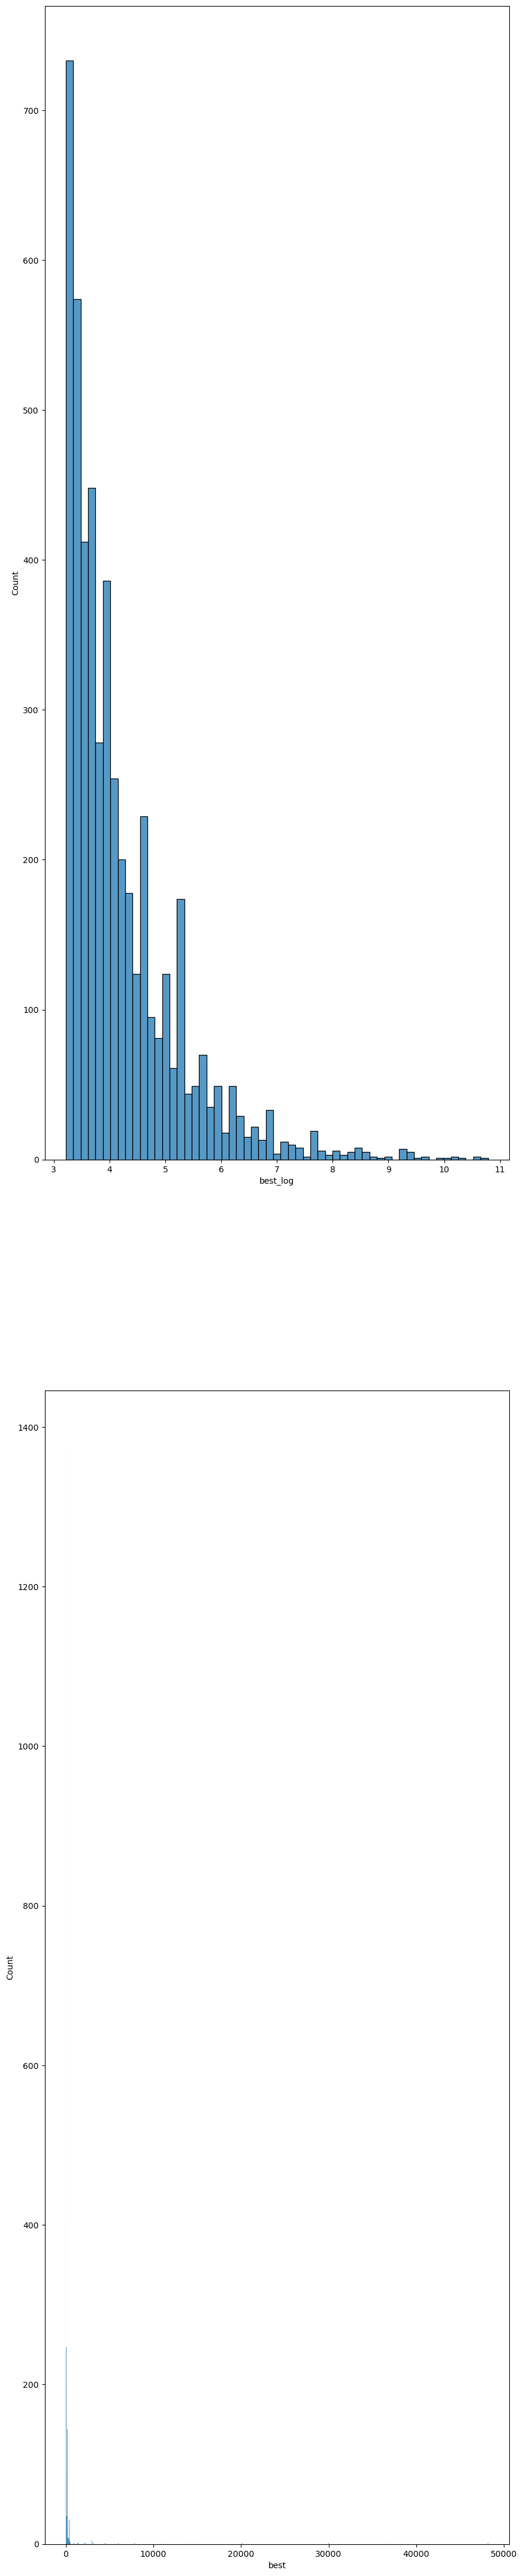

In [41]:
#now that all the zeros have been eliminated, log transfrom the best fatalities estimates
df_conflict['best_log'] = np.log(df_conflict['best'])
#compare skewed and logtransformed best
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
figure, axes = plt.subplots(2,1,figsize=(10,55))
sns.histplot(df_conflict['best_log'],ax=axes[0])
sns.histplot(df_conflict['best'],ax=axes[1])

plt.savefig('conflict_log.png')

In [24]:
#create the neighbouring country at war index, best >= 25
#first try it for one country
dza_neighbors = Country.from_iso('DZA', month_id=455).neighbors()

print('dza neighbour ID: ', dza_neighbors)
print()
print('dza neighbour names:', [i.name for i in dza_neighbors])

ago_neighbors = Country.from_iso('AGO', month_id=455).neighbors()

print('ago neighbour ID: ', ago_neighbors)
print()
print('ago neighbour names:', [i.name for i in ago_neighbors])

ben_neighbors = Country.from_iso('BEN', month_id=455).neighbors()

print('dza neighbour ID: ', dza_neighbors)
print()
print('dza neighbour names:', [i.name for i in dza_neighbors])dza_neighbors = Country.from_iso('DZA', month_id=455).neighbors()

print('dza neighbour ID: ', dza_neighbors)
print()
print('dza neighbour names:', [i.name for i in dza_neighbors])

dza_neighbors = Country.from_iso('DZA', month_id=455).neighbors()

print('dza neighbour ID: ', dza_neighbors)
print()
print('dza neighbour names:', [i.name for i in dza_neighbors])dza_neighbors = Country.from_iso('DZA', month_id=455).neighbors()

print('dza neighbour ID: ', dza_neighbors)
print()
print('dza neighbour names:', [i.name for i in dza_neighbors])

dza neighbour ID:  [Country(50), Country(73), Country(78), Country(213), Country(243), Country(244)]

dza neighbour names: ['Mali', 'Tunisia', 'Niger', 'Libya', 'Morocco', 'Mauritania']


In [44]:
for i in df_conflict['iso']:
    neighbors = Country.from_iso(i,month_id =455).neighbors()
    print('neighbour ID: ', neighbors)
    print()

neighbour ID:  [Country(50), Country(73), Country(78), Country(213), Country(243), Country(244)]

neighbour ID:  [Country(50), Country(73), Country(78), Country(213), Country(243), Country(244)]

neighbour ID:  [Country(50), Country(73), Country(78), Country(213), Country(243), Country(244)]

neighbour ID:  [Country(50), Country(73), Country(78), Country(213), Country(243), Country(244)]

neighbour ID:  [Country(50), Country(73), Country(78), Country(213), Country(243), Country(244)]

neighbour ID:  [Country(50), Country(73), Country(78), Country(213), Country(243), Country(244)]

neighbour ID:  [Country(50), Country(73), Country(78), Country(213), Country(243), Country(244)]

neighbour ID:  [Country(50), Country(73), Country(78), Country(213), Country(243), Country(244)]

neighbour ID:  [Country(50), Country(73), Country(78), Country(213), Country(243), Country(244)]

neighbour ID:  [Country(50), Country(73), Country(78), Country(213), Country(243), Country(244)]

neighbour ID:  [Coun

In [ ]:
neighbors

In [26]:
#create columns for all scenarios?
data_sb = df_conflict.query('dummy_sb == 1')
data_os = df_conflict.query('dummy_os == 1')
data_ns = df_conflict.query('dummy_ns == 1') 

data_low_intensity = df_conflict.query('dummy_low_intensity == 1')
data_medium_intensity = df_conflict.query('dummy_medium_intensity == 1')
data_high_intensity = df_conflict.query('dummy_high_intensity == 1')

UndefinedVariableError: name 'dummy_sb' is not defined

In [42]:
df_conflict.to_csv('df_conflict.csv')